
--- Reading output rate HP 3458H (new) via USB-GPIB: ---
Total Readings: 907264
Total Duration: 0 days 10:44:09.405995
Average Readings per Second: 23.4742 Hz
Mean Time Between Readings (μ_Δt): 0.042600 seconds
Standard Deviation of Δt (σ_Δt): 0.000072 seconds
Minimum Δt: 0.036987 seconds
Maximum Δt: 0.048314 seconds
Maximum ΔU in 50-sample intervals is: 5.717012e-07

--- Reading output rate Keysight 3458B via USB-GPIB: ---
Total Readings: 1088328
Total Duration: 0 days 12:57:38.873214
Average Readings per Second: 23.3252 Hz
Mean Time Between Readings (μ_Δt): 0.042872 seconds
Standard Deviation of Δt (σ_Δt): 0.000078 seconds
Minimum Δt: 0.035919 seconds
Maximum Δt: 0.049891 seconds
Maximum ΔU in 50-sample intervals is: -1.184709e-05

--- Reading output rate HP 3458P via USB-GPIB: ---
Total Readings: 1155854
Total Duration: 0 days 13:45:43.365607
Average Readings per Second: 23.3301 Hz
Mean Time Between Readings (μ_Δt): 0.042863 seconds
Standard Deviation of Δt (σ_Δt): 0.000084 seconds

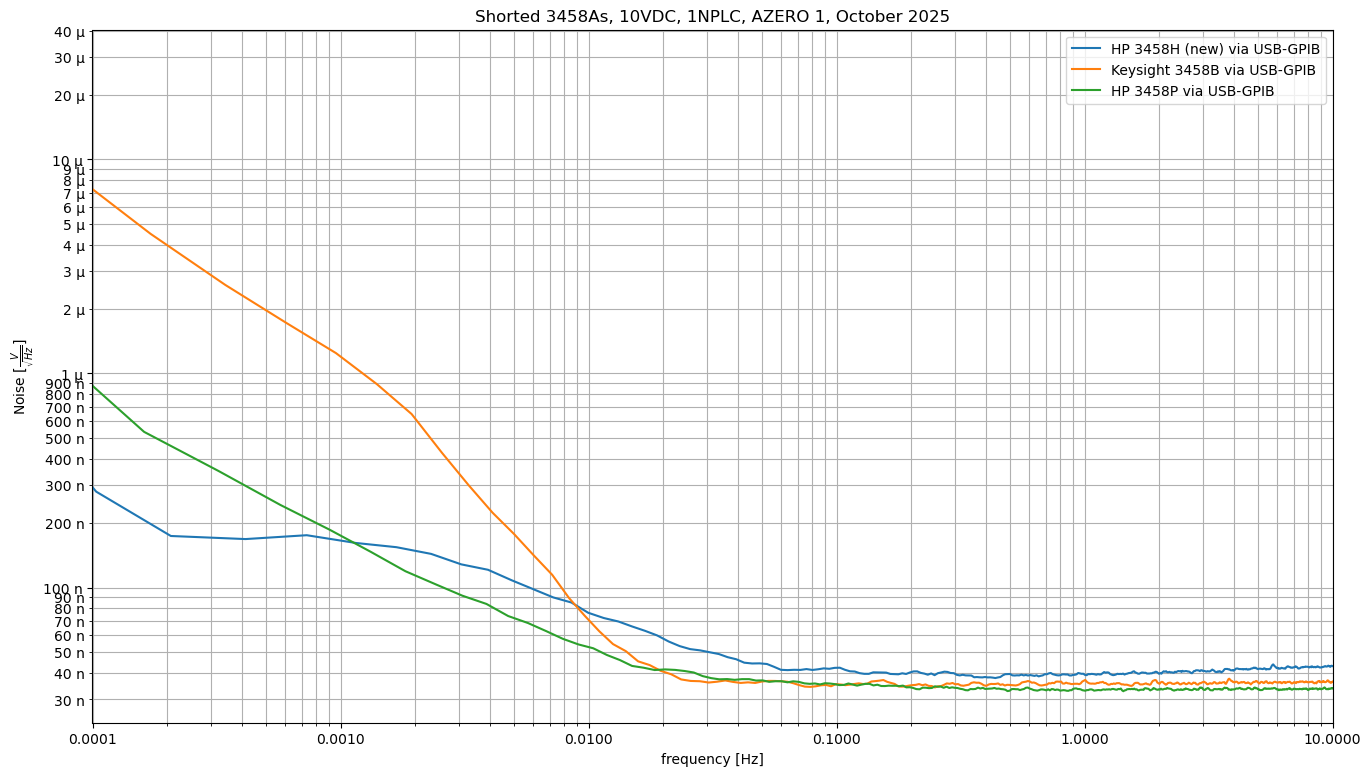

In [12]:
import pandas as pd
from lpsd import lpsd, flattop # https://gitlab.com/uhh-gwd/lpsd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import EngFormatter

# Set up plot
fig,ax = plt.subplots(figsize=(16,9))
plt.loglog()
plt.xlim([0.0001,10])
plt.xlabel('frequency [Hz]')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.yaxis.set_major_formatter(EngFormatter())
ax.yaxis.set_minor_formatter(EngFormatter())
plt.ylabel(r'Noise [$\frac{V}{\sqrt{Hz}}$]')
plt.grid(True, which="both")
plt.title('Shorted 3458As, 10VDC, 1NPLC, AZERO 1, October 2025')


def process(csv_url, meter_name):
    # Array from .csv
    df = pd.read_csv(csv_url)
    df.columns = ['time', 'voltage_reading']
    df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
    total_readings = len(df)
    total_duration = df['time'].iloc[-1] - df['time'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()
    avg_readings_per_second = total_readings / total_duration_seconds
    print("\n--- Reading output rate "+meter_name+": ---")
    print(f"Total Readings: {total_readings}")
    print(f"Total Duration: {total_duration}")
    print(f"Average Readings per Second: {avg_readings_per_second:.4f} Hz")

    df['delta_t'] = df['time'].diff().dt.total_seconds()
    delta_t = df['delta_t'].dropna()
    mean_delta_t = delta_t.mean()
    std_delta_t = delta_t.std()
    min_delta_t = delta_t.min()
    max_delta_t = delta_t.max()
    print(f"Mean Time Between Readings (μ_Δt): {mean_delta_t:.6f} seconds") 
    print(f"Standard Deviation of Δt (σ_Δt): {std_delta_t:.6f} seconds")
    print(f"Minimum Δt: {min_delta_t:.6f} seconds")
    print(f"Maximum Δt: {max_delta_t:.6f} seconds")
    
    rolling_max = df['voltage_reading'].rolling(window=50).max()
    rolling_min = df['voltage_reading'].rolling(window=50).min()
    print(f"Maximum ΔU in 50-sample intervals is: {rolling_max.max():.6e}")

    spectrum = lpsd(df.iloc[:, 1], sample_rate=avg_readings_per_second, n_frequencies=100000, n_averages=300000, window_function=flattop.HFT90D, overlap = flattop.olap_dict["HFT90D"], detrending_order=1)
    plt.plot(spectrum.index, spectrum["asd"], label=meter_name)
    
process('https://github.com/marcoreps/3458a/raw/refs/heads/main/csv/3458H_short_10V_1NPLC_az_on_20251009-222625.csv', 'HP 3458H (new) via USB-GPIB')
process('https://github.com/marcoreps/3458a/raw/refs/heads/main/csv/3458B_short_10V_1NPLC_az_on_20251010-182421.csv', 'Keysight 3458B via USB-GPIB')
process('https://github.com/marcoreps/3458a/raw/refs/heads/main/csv/3458A_short_10V_1NPLC_az_on_20251011-073745.csv', 'HP 3458P via USB-GPIB')


plt.legend()